<a href="https://colab.research.google.com/github/EnisBerk/speech_audio_understanding/blob/master/kaggle_speech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Enis Berk Çoban
## Project - 1


# A Notebook for Simple Speech Commands Detection Competition

Voice interfaces are getting more popular everyday, concuring every part of our life, from Siri to Amazon Echo. 

However,  for independent makers and entrepreneurs, it’s hard to build a simple speech detector using free, open data and code. To challenge this problem TensorFlow released the Speech Commands Datasets. It includes 65,000 one-second long utterances of 30 short words, by thousands of different people.

With this data, developers are challenged to use the Speech Commands Dataset to build an algorithm that understands simple spoken commands. 


Content:<br>
* [0. Start](#scrollTo=OnWjKDX6nYY9)
    * Load libraries
    * Download data
    
* [1. Data set](#scrollTo=knWNXNRvWyIF&line=15&uniqifier=1)
* [2.Signal Processing](#scrollTo=zW_0ToIZxsXr)  
    * [Visual explanations](#scrollTo=uL56VCAwFFMV)
    * [Spectogram](#scrollTo=FVtSfFzqEjhs)
    * [Raw format](#scrollTo=TQ0aWAIiCBg9)
    * [Mel scale](#scrollTo=1RkZg_WoZz7W)
* [3. Data set details](#scrollTo=f-UZcDoiYg2a)
  * [Label counts](#scrollTo=g8ihPBnpWMxB&line=10&uniqifier=1)
  * [Mean FFT of all words](#scrollTo=ztens29EczMp&line=2&uniqifier=1)
* [4 Deep Learning](#scrollTo=4KYQw17gxIeW&line=4&uniqifier=1)  
  * [4.1 Load Data]
  * [4.2 Data Reader Function]
  * [4.3 Model Definition]
  * [4.4 Define training and evaluation steps]
  * [4.5 Define parameters]
  * [4.6 Running the training]
  * [4.7 Results]
* [5 Conclusion](#scrollTo=yOwpSx2L4dim&line=3&uniqifier=1)

* [6 Bibliography](#scrollTo=nsrcbxmt6Mkv)




# 0. Start
Load required libraries and download data.

In [4]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd


import re
from glob import glob

# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py

py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

#kaggle api
# import kaggle

%matplotlib inline

#paths
train_audio_path = './data/speech_commands_kaggle/train/audio/'

class bcolors:
	HEADER = '\033[95m'
	OKBLUE = '\033[94m'
	OKGREEN = '\033[92m'
	WARNING = '\033[93m'
	FAIL = '\033[91m'
	ENDC = '\033[0m'
	BOLD = '\033[1m'
	UNDERLINE = '\033[4m'
  
  
DATADIR = './data/speech_commands_kaggle/' # unzipped train and test data
OUTDIR = './model-k' # just a random name



In [2]:
# FOR ORIGINAL DATASET FROM GOOGLE

# # Download data
# # Dataset is updated (April 11th 2018) after the competition, we will use old version 
# version="0.01" #65,000 audio file
# # version="0.02" #105,829 audio files

# data_folder='../data/'
# speech_folder_path="../data/speech_commands_v"+version+"/"

# data_url="http://download.tensorflow.org/data/speech_commands_v"+version+".tar.gz"
# data_file=data_folder+"speech_commands_v"+version+".tar.gz"

# # Create  a folder for data
# if not os.path.exists(data_folder):
#     os.makedirs(data_folder)
# if not os.path.exists(speech_folder_path):
#     os.makedirs(speech_folder_path)

# # Download dataset
# !wget -O $data_file $data_url
# !tar -xzf $data_file --directory=$speech_folder_path


#DOWNLOAD FROM KAGGLE (requires kaggle api key)
# from google.colab import files

# uploaded = files.upload()
# !kaggle competitions download -c tensorflow-speech-recognition-challenge

#DOWNLOAD FROM GC
from google.colab import auth
auth.authenticate_user()

!mkdir -p ./data/speech_commands_kaggle
!gsutil cp -p gs://deep_learning_enis/speech_audio_understanding/kaggle/test.tar.gz ./data
!gsutil cp -p gs://deep_learning_enis/speech_audio_understanding/kaggle/train.tar.gz ./data
!tar -xzf ./data/test.tar.gz -C ./data/speech_commands_kaggle
!tar -xzf ./data/train.tar.gz -C ./data/speech_commands_kaggle



Copying gs://deep_learning_enis/speech_audio_understanding/kaggle/test.tar.gz...
- [1 files][  6.0 GiB/  6.0 GiB]   66.1 MiB/s                                   
Operation completed over 1 objects/6.0 GiB.                                      
Copying gs://deep_learning_enis/speech_audio_understanding/kaggle/train.tar.gz...
- [1 files][  2.8 GiB/  2.8 GiB]   63.6 MiB/s                                   
Operation completed over 1 objects/2.8 GiB.                                      


In [0]:
!rm ./data/test.tar.gz
!rm ./data/train.tar.gz

# 1. Dataset 
It includes **65,000** audio files, one-second long utterances of 30 short words, by thousands of different people.  
Such as "yes","no","up" ..  
data folder "speech_commands" includes folders named after each command<br>
>./data
>>/speech_commands_kaggle
>>>/train
>>>>/audio
>>>>>/yes
>>>>>>0a7c2a8d_nohash_0.wav

>>>>>/no

File namings:  
**0a7c2a8d**_*nohash*_0.wav :  
**0a7c2a8d ** --> speaker's id,   
*nohash* for sorting reasons,  
0 means first utterance of that word by this speaker in the data set  

Chechout ../data/speech_commands/README.md for details

In [0]:
filename = '/yes/0a7c2a8d_nohash_0.wav'
sample_rate, samples = wavfile.read(str(train_audio_path) + filename)

In [7]:
print("number of samples",len(samples))
print("sampling rate",sample_rate)
print("sampling rate is equal to number of samples ",sample_rate==len(samples))
print("because each file is 1 second")

number of samples 16000
sampling rate 16000
sampling rate is equal to number of samples  True
because each file is 1 second


# 2. Signal Processing 

Our dataset is consists of sounds which are basicly signals.  For this reason understanding basics of signal processing is helpful. 



Sound can be stored as amplitude over time. 
Wav files stores the amplitude of the analog signal which is sampled regularly at uniform intervals, and each sample is quantized to the nearest value within a range of digital steps.

However this is not really helpful to differentiate them one from another.
Solution is finding amplitude per frequency so we will have amplitude over each frequency.
We can get this represenation with fourier transform (FT) which converts signal from time domain to frequency domain.
![Fourier Transform](https://upload.wikimedia.org/wikipedia/commons/thumb/5/51/Fourier_unit_pulse.svg/600px-Fourier_unit_pulse.svg.png)

However, after FT conversion, we loose time domain, all time domain becomes smashed into one point. 
As a solution we pick time windows and take forier transform over those windows. This is called STFT.  ([Short-time fourier transform](https://en.wikipedia.org/wiki/Short-time_Fourier_transform))

Then problem is some of the patterns might be longer than our window size.  
As a solution we can have overlapping windowses.

Check speech processing course slides for details: [Speech and audio processing](https://hyp.is/go?url=http%3A%2F%2Fm.mr-pc.org%2Ft%2Fcsc83060%2F2019sp%2Flecture02.pdf)



## 2.1 An example signal and visulisations of it 

In [0]:
# if you think a signal with sampling frequency of 1,000 (fs)
fs=10e3
# lets say there N samples
N = 1e5
# and lets assume our amplitude is 2*2*(1/2) = 2.82
amp = 2 * np.sqrt(2)

#lets get some noise also 
noise_power = 0.01 * fs / 2

# our time array will have stamps for each 1/fs second, if we have N samples, Nth sample is collected at N/sampling_rate time
# so our time array have seconds, each 1000th sample is collected at the end of the 1 second cycle
time = np.arange(N) / float(fs)
# cos(pi*k) cycles with every time k=0,2,4,6 etc
# cos(pi*k*0.5) cycles with every time k=0,4,8,12 etc
mod = 500*np.cos(2*np.pi*0.25*time)

# np.sin(2*np.pi*3e3*k) cycles every 500 value of k,
# np.sin(2*np.pi*3e3*time so time values turned into a signal of repeating 
carrier = amp * np.sin(2*np.pi*3e3*time + mod)

# use normal disribution to generate noise
noise = np.random.normal(scale=np.sqrt(noise_power), size=time.shape)
# I do not know why we need this , probably to keep noise low compared to signal
noise *= np.exp(-time/5)

x = carrier + noise

In [9]:
# now 
print("length of x (signal) is",len(x),"\n first 4 element of x",x[0:4])

#taking sfft and and visulising it 
f, t, Sxx = signal.spectrogram(x, fs)

# f is array of sample frequencies
print("size of array of frequencies",len(f))
# t is Array of segment times.
print("segment times",len(t))
# Sxx is spectrogram of x. By default, the last axis of Sxx corresponds to the segment times.

print("shape of spectogram array",Sxx.shape)
print("an example value from spectogram",Sxx[0][0])

length of x (signal) is 100000 
 first 4 element of x [-3.67386859 -9.79986202  4.47238174 -0.20923657]
size of array of frequencies 129
segment times 446
shape of spectogram array (129, 446)
an example value from spectogram 0.0010044174834663844


## 2.2 Spectogram
Following figure is visulisation of our signal as a spectogram:

Text(0.5, 0, 'Time [sec]')

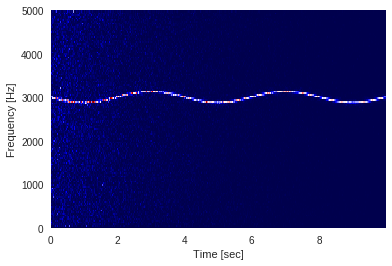

In [10]:
plt.pcolormesh(t, f, Sxx, cmap="seismic")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

## 2.3
Lets get a sound file and look into spectrum of it as well:

We pick a sound that we hear "Yes"

In [11]:
train_audio_path = "./data/speech_commands_kaggle/train/audio/"
filename = "yes/004ae714_nohash_0.wav"
# speech_audio_understanding/data/speech_comands_kaggle/train/audio/yes/004ae714_nohash_0.wav

# scipy.io have wavfile functio to read vaw files
# returns a int and numpy array
sample_rate, samples = wavfile.read(train_audio_path+filename)
ipd.Audio(train_audio_path+filename)

Raw wave form of  a sound "yes"

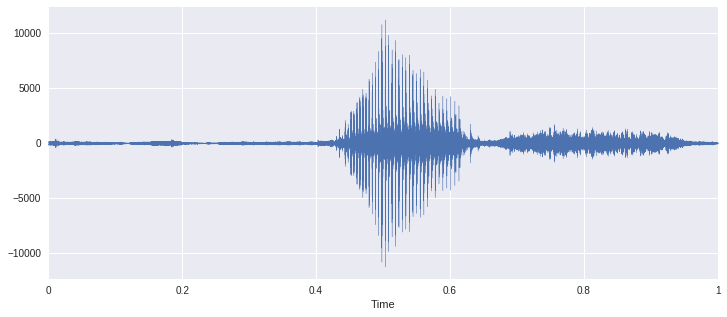

In [12]:
plt.figure(figsize=(12, 5))
librosa.display.waveplot(samples.astype(np.float32), sr=sample_rate)

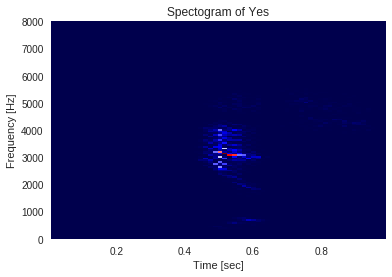

In [13]:

f, t, Sxx = signal.spectrogram(samples, sample_rate,)
plt.pcolormesh(t, f, Sxx,cmap='seismic')
plt.title("Spectogram of Yes")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

We can take logarithm of spectrogram values so that our plot will be more easier to understand.


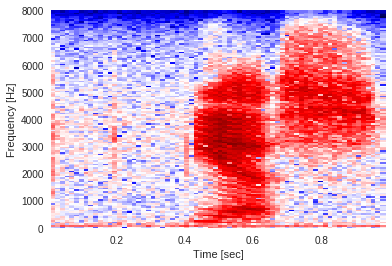

In [14]:
eps=1e-10
Sxx_log=np.log(Sxx + eps)
# f, t, Sxx = signal.spectrogram(freqs, sample_rate)
plt.pcolormesh(t, f, Sxx_log, cmap="seismic")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

## 2.3 Mel Scale

"*The Mel scale relates perceived frequency, or pitch, of a pure tone to its actual measured frequency. Humans are much better at discerning small changes in pitch at low frequencies than they are at high frequencies. Incorporating this scale makes our features match more closely what humans hear.*" [1]

Equation 1 shows how to transform frequency to mel-scale:
![ ](http://practicalcryptography.com/media/latex/369d64804e572729863c874aaa092e582bf5eb56-11pt.png)

Using mel-spectrum can help us understand it better:




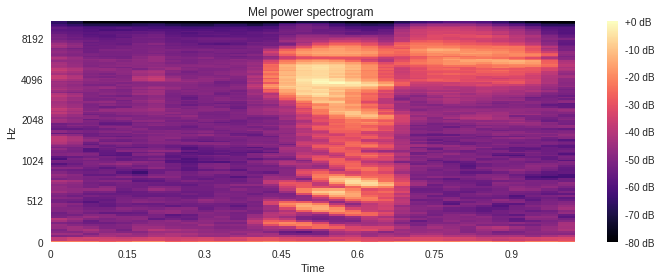

In [15]:
S = librosa.feature.melspectrogram(samples.astype(np.float32), sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

Human speech is generated with vocal tract including tongue and teeth etc. Sound takes shape depending on those. So phonemes are can be identified with the shape of speech sound. Those shapes can be identified with envelope of short time power spectrums and Mel Frequency Cepstral Coefficient can accuratly represent that envelople. [1]









# 3. Data set details
- Number of Labels 
- Number of records in each label 
- Check if all recordings have 1 second length

### 3.1 Number of labels

In [10]:
dirs = [f for f in os.listdir(train_audio_path) if isdir(join(train_audio_path, f))]
dirs.sort()
print('Number of labels: ' + str(len(dirs)))

Number of labels: 31


In [0]:
# Required for plotly visaulisations on google colab

def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

In [31]:
# Calculate
configure_plotly_browser_state()

number_of_recordings = []
for direct in dirs:
    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    number_of_recordings.append(len(waves))

# Plot
data = [go.Histogram(x=dirs, y=number_of_recordings)]
trace = go.Bar(
    x=dirs,
    y=number_of_recordings,
    marker=dict(color = number_of_recordings, colorscale='Viridis', showscale=True
    ),
)
layout = go.Layout(
    title='Number of recordings in given label',
    xaxis = dict(title='Words'),
    yaxis = dict(title='Number of recordings')
)
py.iplot(go.Figure(data=[trace], layout=layout))


In [47]:
num_of_shorter = 0
total=0
for direct in dirs:
    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + direct + '/' + wav)
        if samples.shape[0] < sample_rate:
            num_of_shorter += 1
        total+=1
print('{}Number of recordings shorter than 1 second: {} out of {} = {:04.2f} percent{}'.format(bcolors.BOLD,num_of_shorter,total,num_of_shorter/total,bcolors.ENDC))

/usr/local/lib/python3.6/dist-packages/scipy/io/wavfile.py:273: WavFileWarning:

Chunk (non-data) not understood, skipping it.



Number of recordings shorter than 1 second: 6469 out of 64727 = 0.10 percent


## 3.2 Mean FFT Scores
Competition only covers 12 possible labels for the Test set: yes, no, up, down, left, right, on, off, stop, go, silence, unknown.

Let's plot mean FFT for every word:

['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes']


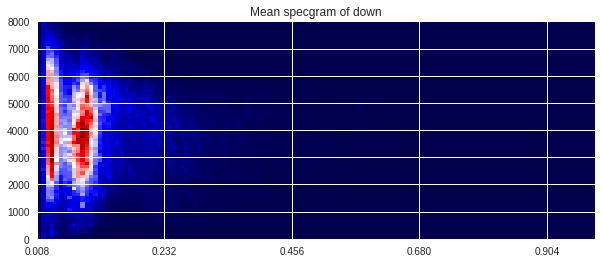

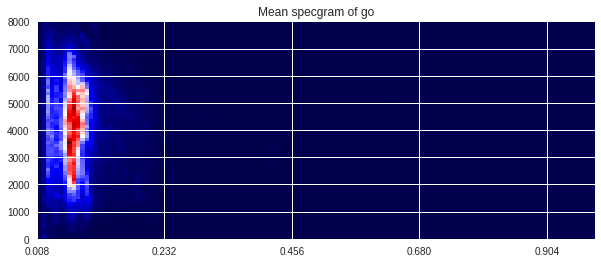

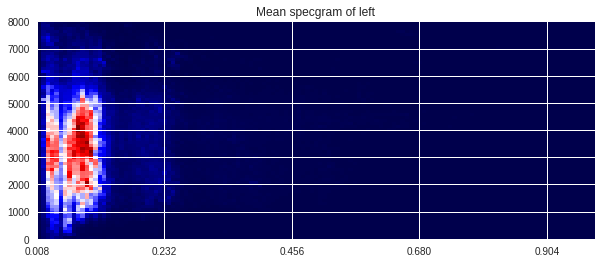

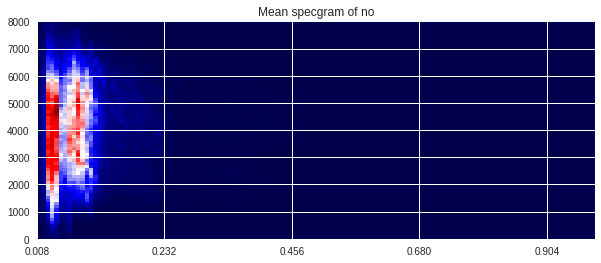

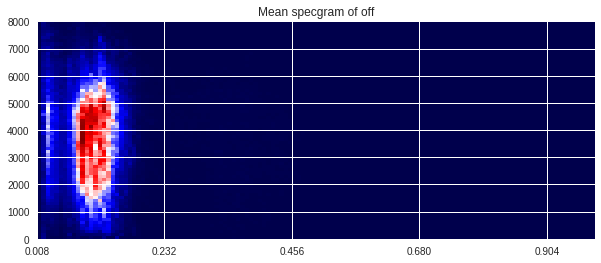

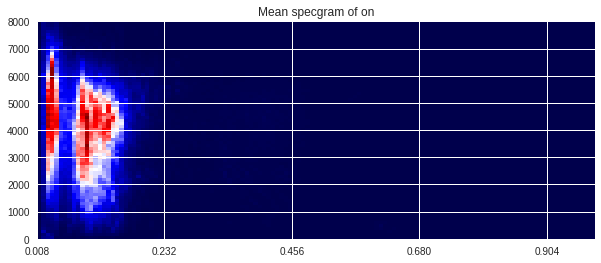

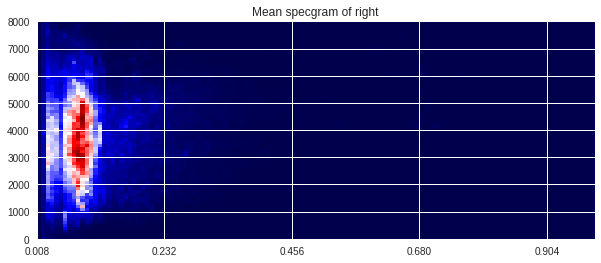

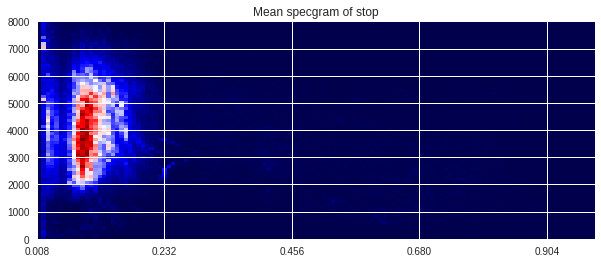

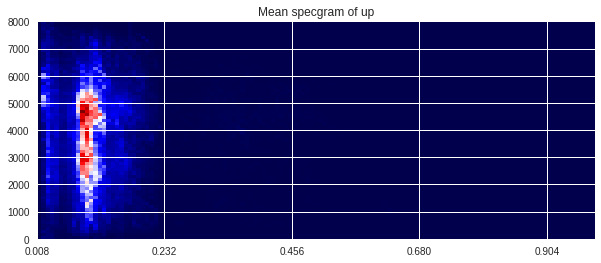

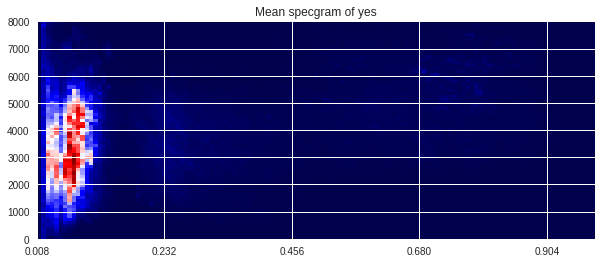

In [53]:
to_keep = 'yes no up down left right on off stop go'.split()
dirs = [d for d in dirs if d in to_keep]

print(dirs)

for direct in dirs:
    vals_all = []
    spec_all = []

    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + direct + '/' + wav)
        if samples.shape[0] != 16000:
            continue
        freqs, times, Sxx = signal.spectrogram(samples, sample_rate)
#         Sxx_log=np.log(Sxx + eps)
        spec_all.append(Sxx)

    plt.figure(figsize=(10, 4))
#     plt.subplot(121)
#     plt.title('Mean fft of ' + direct)
#     plt.plot(np.mean(np.array(vals_all), axis=0))
#     plt.grid()
#     plt.subplot(122)
    plt.title('Mean specgram of ' + direct)
    plt.imshow(np.mean(np.array(spec_all), axis=0).T, aspect='auto', origin='lower', 
               extent=[times.min(), times.max(), freqs.min(), freqs.max()],cmap="seismic")
    plt.yticks(freqs[::16])
    plt.xticks(times[::16])
    plt.show()

# 4.  Basic Deep Learning 

I will use tensorflow esimator which is high level API for using deep learning algorithms. [docs](https://www.tensorflow.org/api_docs/python/tf/estimator/Estimator) 


## 4.1 Load data

In [5]:

POSSIBLE_LABELS = 'yes no up down left right on off stop go silence unknown'.split()
id2name = {i: name for i, name in enumerate(POSSIBLE_LABELS)}
name2id = {name: i for i, name in id2name.items()}

# data loader function
def load_data(data_dir):
    """ Return 2 lists of tuples:
    [(class_id, user_id, path), ...] for train
    [(class_id, user_id, path), ...] for validation
    """
    # Just a simple regexp for paths with three groups:
    # prefix, label, user_id
    pattern = re.compile("(.+\/)?(\w+)\/([^_]+)_.+wav")
    all_files = glob(os.path.join(data_dir, 'train/audio/*/*wav'))

    with open(os.path.join(data_dir, 'train/validation_list.txt'), 'r') as fin:
        validation_files = fin.readlines()
    valset = set()
    for entry in validation_files:
        r = re.match(pattern, entry)
        if r:
            valset.add(r.group(3))

    possible = set(POSSIBLE_LABELS)
    train, val = [], []
    for entry in all_files:
        r = re.match(pattern, entry)
        if r:
            label, uid = r.group(2), r.group(3)
            if label == '_background_noise_':
                label = 'silence'
            if label not in possible:
                label = 'unknown'

            label_id = name2id[label]

            sample = (label_id, uid, entry)
            if uid in valset:
                val.append(sample)
            else:
                train.append(sample)

    print('There are {} train and {} val samples'.format(len(train), len(val)))
    return train, val

trainset, valset = load_data(DATADIR)

There are 57929 train and 6798 val samples


## 4.2 Data Reader function:

Tensorflow uses this function to read data. 
We padd small sounds with zero.

And generate silence to increase training data.

Then associate labels and data.

In [0]:
def data_generator(data, params, mode='train'):
    def generator():
        if mode == 'train':
            np.random.shuffle(data)
        # Feel free to add any augmentation
        for (label_id, uid, fname) in data:
            try:
                _, wav = wavfile.read(fname)
                wav = wav.astype(np.float32) / np.iinfo(np.int16).max

                L = 16000  # be aware, some files are shorter than 1 sec!
                if len(wav) < L:
                    continue
                # let's generate more silence!
                samples_per_file = 1 if label_id != name2id['silence'] else 20
                for _ in range(samples_per_file):
                    if len(wav) > L:
                        beg = np.random.randint(0, len(wav) - L)
                    else:
                        beg = 0
                    yield dict(
                        target=np.int32(label_id),
                        wav=wav[beg: beg + L],
                    )
            except Exception as err:
                print(err, label_id, uid, fname)

    return generator

## 4.3 Model definition

We will use a simple model with four layers of CNNs and pooling. 

In [0]:
import tensorflow as tf
from tensorflow.contrib import layers

def baseline(x, params, is_training):
    x = layers.batch_norm(x, is_training=is_training)
    for i in range(4):
        x = layers.conv2d(
            x, 16 * (2 ** i), 3, 1,
            activation_fn=tf.nn.elu,
            normalizer_fn=layers.batch_norm if params.use_batch_norm else None,
            normalizer_params={'is_training': is_training}
        )
        x = layers.max_pool2d(x, 2, 2)

    # just take two kind of pooling and then mix them
    mpool = tf.reduce_max(x, axis=[1, 2], keep_dims=True)
    apool = tf.reduce_mean(x, axis=[1, 2], keep_dims=True)

    x = 0.5 * (mpool + apool)
    # we can use conv2d 1x1 instead of dense
    x = layers.conv2d(x, 128, 1, 1, activation_fn=tf.nn.elu)
    x = tf.nn.dropout(x, keep_prob=params.keep_prob if is_training else 1.0)
    
    # again conv2d 1x1 instead of dense layer
    logits = layers.conv2d(x, params.num_classes, 1, 1, activation_fn=None)
    return tf.squeeze(logits, [1, 2])

## 4.4 Define training and evaluation steps

We define functions to pre-process data then define following steps:

* train
* eval
* predict

In [0]:
from tensorflow.contrib import signal

# features is a dict with keys: tensors from our datagenerator
# labels also were in features, but excluded in generator_input_fn by target_key

def model_handler(features, labels, mode, params, config):
    # Im really like to use make_template instead of variable_scopes and re-usage
    extractor = tf.make_template(
        'extractor', baseline,
        create_scope_now_=True,
    )
    # wav is a waveform signal with shape (16000, )
    wav = features['wav']
    # we want to compute spectograms by means of short time fourier transform:
    specgram = signal.stft(
        wav,
        400,  # 16000 [samples per second] * 0.025 [s] -- default stft window frame
        160,  # 16000 * 0.010 -- default stride
    )
    # specgram is a complex tensor, so split it into abs and phase parts:
    phase = tf.angle(specgram) / np.pi
    # log(1 + abs) is a default transformation for energy units
    amp = tf.log1p(tf.abs(specgram))
    
    x = tf.stack([amp, phase], axis=3) # shape is [bs, time, freq_bins, 2]
    x = tf.to_float(x)  # we want to have float32, not float64

    logits = extractor(x, params, mode == tf.estimator.ModeKeys.TRAIN)

    if mode == tf.estimator.ModeKeys.TRAIN:
        loss = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits))
        # some lr tuner, you could use move interesting functions
        def learning_rate_decay_fn(learning_rate, global_step):
            return tf.train.exponential_decay(
                learning_rate, global_step, decay_steps=10000, decay_rate=0.99)

        train_op = tf.contrib.layers.optimize_loss(
            loss=loss,
            global_step=tf.contrib.framework.get_global_step(),
            learning_rate=params.learning_rate,
            optimizer=lambda lr: tf.train.MomentumOptimizer(lr, 0.9, use_nesterov=True),
            learning_rate_decay_fn=learning_rate_decay_fn,
            clip_gradients=params.clip_gradients,
            variables=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES))

        specs = dict(
            mode=mode,
            loss=loss,
            train_op=train_op,
        )

    if mode == tf.estimator.ModeKeys.EVAL:
        prediction = tf.argmax(logits, axis=-1)
        acc, acc_op = tf.metrics.mean_per_class_accuracy(
            labels, prediction, params.num_classes)
        loss = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits))
        specs = dict(
            mode=mode,
            loss=loss,
            eval_metric_ops=dict(
                acc=(acc, acc_op),
            )
        )

    if mode == tf.estimator.ModeKeys.PREDICT:
        predictions = {
            'label': tf.argmax(logits, axis=-1),  # for probability just take tf.nn.softmax()
            'sample': features['sample'], # it's a hack for simplicity
        }
        specs = dict(
            mode=mode,
            predictions=predictions,
        )
    return tf.estimator.EstimatorSpec(**specs)


def create_model(config=None, hparams=None):
    return tf.estimator.Estimator(
        model_fn=model_handler,
        config=config,
        params=hparams,
    )

## 4.5 Define  parameters

Move model hyperparams (optimizer, extractor, num of layers, activation fn, ...) here

In [0]:
params=dict(
    seed=2018,
    batch_size=64,
    keep_prob=0.5,
    learning_rate=1e-3,
    clip_gradients=15.0,
    use_batch_norm=True,
    num_classes=len(POSSIBLE_LABELS),
)

hparams = tf.contrib.training.HParams(**params)
os.makedirs(os.path.join(OUTDIR, 'eval'), exist_ok=True)
model_dir = OUTDIR

run_config = tf.contrib.learn.RunConfig(model_dir=model_dir)

## 4.5 Running the training

In [12]:
from tensorflow.contrib.learn.python.learn.learn_io.generator_io import generator_input_fn
            
train_input_fn = generator_input_fn(
    x=data_generator(trainset, hparams, 'train'),
    target_key='target', 
    batch_size=hparams.batch_size, shuffle=True, num_epochs=None,
    queue_capacity=3 * hparams.batch_size + 10, num_threads=1,
)

val_input_fn = generator_input_fn(
    x=data_generator(valset, hparams, 'val'),
    target_key='target',
    batch_size=hparams.batch_size, shuffle=True, num_epochs=None,
    queue_capacity=3 * hparams.batch_size + 10, num_threads=1,
)
            

def _create_my_experiment(run_config, hparams):
    exp = tf.contrib.learn.Experiment(
        estimator=create_model(config=run_config, hparams=hparams),
        train_input_fn=train_input_fn,
        eval_input_fn=val_input_fn,
        train_steps=10000, 
        eval_steps=200,  
        train_steps_per_iteration=1000,
    )
    return exp

tf.contrib.learn.learn_runner.run(
    experiment_fn=_create_my_experiment,
    run_config=run_config,
    schedule="continuous_train_and_eval",
    hparams=hparams)

Instructions for updating:
Please use tf.data.
Instructions for updating:
Use tf.estimator.train_and_evaluate.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fabeddae588>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_eval_distribute': None, '_device_fn': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_protocol': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': './model-k'}
Instructions for updating:
Please switch to tf.estimator.train_

/usr/local/lib/python3.6/dist-packages/scipy/io/wavfile.py:273: WavFileWarning:

Chunk (non-data) not understood, skipping it.



INFO:tensorflow:global_step/sec: 12.4429
INFO:tensorflow:loss = 1.0225649, step = 200 (8.033 sec)
INFO:tensorflow:global_step/sec: 12.4506
INFO:tensorflow:loss = 1.2421129, step = 300 (8.036 sec)
INFO:tensorflow:global_step/sec: 12.5859
INFO:tensorflow:loss = 0.9417739, step = 400 (7.944 sec)
INFO:tensorflow:global_step/sec: 12.4686
INFO:tensorflow:loss = 0.95125234, step = 500 (8.020 sec)
INFO:tensorflow:global_step/sec: 12.3301
INFO:tensorflow:loss = 0.7983146, step = 600 (8.111 sec)
INFO:tensorflow:global_step/sec: 12.6856
INFO:tensorflow:loss = 0.90861964, step = 700 (7.881 sec)
INFO:tensorflow:global_step/sec: 12.6341
INFO:tensorflow:loss = 0.9201632, step = 800 (7.912 sec)
INFO:tensorflow:global_step/sec: 12.4644
INFO:tensorflow:loss = 0.6693942, step = 900 (8.027 sec)
INFO:tensorflow:Saving checkpoints for 1000 into ./model-k/model.ckpt.
INFO:tensorflow:Loss for final step: 0.56868196.
INFO:tensorflow:Evaluating model now.
INFO:tensorflow:Calling model_fn.
Instructions for updat

({'acc': 0.8062348, 'global_step': 10000, 'loss': 0.25901654}, [])

## 4.6 Results 

Our simple model got accuracy of 0.806 with loss of 0.25. 


# 5. Conclusion

In this notebook, I started with explaning importance of open source speech detection and its impact. 
Tensorflow speech dataset is an significant advancement in this field. 
Hopefully, we will have more open dataset rather than monopolies in speech processing and voice assistants.

I explained how sound data is handled with state of art techniques. And basic signal processing methods.

Data set is relatively big (8 GB) and pre-processing, loading takes time. However it can fit into GPU memory which enables using deep learning with ease. 

Then, I used a basic convolotional model to create a baseline performance. Training took an hour on K80 gpu with 4 layer CNN model and I got accuracy of 0.806. This baseline shows that deep learning models can be used to achieve good results.

Next step would be using a pre-trained model like VGGish to pre-process audio and use embedings with a custom NN.

Thank you for reading.  
Enis Berk





# 6. Sources:

[1] Mel Frequency Cepstral Coefficient (MFCC)  [link](http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/)

[2] Davis, S. Mermelstein, P. (1980) Comparison of Parametric Representations for Monosyllabic Word Recognition in Continuously Spoken Sentences. In IEEE Transactions on Acoustics, Speech, and Signal Processing, Vol. 28 No. 4, pp. 357-366 [link](https://ieeexplore.ieee.org/document/1163420)

[3] X. Huang, A. Acero, and H. Hon. Spoken Language Processing: A guide to theory, algorithm, and system development. Prentice Hall, 2001. [link](https://dl.acm.org/citation.cfm?id=560905)

[4] Speech and Audio Course by Michael I Mandel [link](http://mr-pc.org/t/#csc83060)

[5] Jupyter Audio Basics [link](https://musicinformationretrieval.com/ipython_audio.html)

[6] Speech data exploration [link](https://www.kaggle.com/davids1992/speech-representation-and-data-exploration)

[7] Tensorflow simple audio [link](https://www.tensorflow.org/tutorials/sequences/audio_recognition)

[8] Google Research announcing the Speech Commands Dataset. [link](https://ai.googleblog.com/2017/08/launching-speech-commands-dataset.html) 

[9] Using CNNs for speech recognition [link](https://www.kaggle.com/alexozerin/end-to-end-baseline-tf-estimator-lb-0-72)
